In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_without_outliers.csv')

X=df.drop(columns=['class'])
y=df['class']

train_split_ratio=0.8
train_rows=round(X.shape[0]*train_split_ratio)


df['class'].replace("UP", 1, inplace=True)   
df['class'].replace("DOWN", 0, inplace=True)
df=df.drop(columns=['id'])

train=df[:train_rows]
test=df[:train_rows]

X_train=X[:train_rows]
y_train=y[:train_rows]

X_test=X[train_rows:]
y_test=y[train_rows:]

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
reframed = series_to_supervised(df.values, 1, 1)
values = reframed.values
# split into input and outputs
train=train.values
test=test.values
train_X, train_y = train[:1000, :-1], train[:1000, -1]
test_X, test_y = test[1000:1200, :-1], test[1000:1200, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1000, 1, 8) (1000,) (200, 1, 8) (200,)


In [ ]:
def generate_data(X, y, sequence_length = 10, step = 1):
    X_local = []
    y_local = []
    for start in range(0, len(df) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

In [ ]:
df.columns

Index(['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice',
       'vicdemand', 'transfer', 'class'],
      dtype='object')

In [ ]:
X_sequence, y = generate_data(df.loc[:,'day':'transfer'].values, df['class'].values)
X_sequence.shape, y.shape

((42858, 10, 7), (42858,))

In [ ]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf

model = keras.Sequential()
model.add(LSTM(100, input_shape = (10, 7)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training_size = int(len(X_sequence) * 0.7)
training_size=26223
X_train, y_train = X_sequence[:training_size], y[:training_size]
X_test, y_test = X_sequence[training_size:], y[training_size:]

In [ ]:
history=model.fit(X_sequence, y, batch_size=256, epochs=30)
#history=model.fit(X_train, y_train, batch_size=256, epochs=30)

Epoch 1/30
168/168 [==============================] - 8s 4ms/step - loss: 0.6598 - binary_accuracy: 0.6066
Epoch 2/30
168/168 [==============================] - 1s 5ms/step - loss: 0.6032 - binary_accuracy: 0.6634
Epoch 3/30
168/168 [==============================] - 1s 5ms/step - loss: 0.5840 - binary_accuracy: 0.6840
Epoch 4/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5691 - binary_accuracy: 0.6986
Epoch 5/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5527 - binary_accuracy: 0.7088
Epoch 6/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5380 - binary_accuracy: 0.7207
Epoch 7/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5225 - binary_accuracy: 0.7324
Epoch 8/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5170 - binary_accuracy: 0.7361
Epoch 9/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5045 - binary_accuracy: 0.7484
Epoch 10/30
168/168 [================

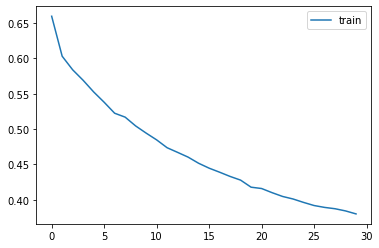

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

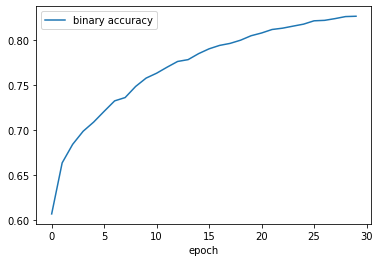

In [ ]:

plt.plot(history.history['binary_accuracy'], label='binary accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

520/520 [==============================] - 2s 3ms/step - loss: 0.3922 - binary_accuracy: 0.8168


[0.3921735882759094, 0.8168320059776306]

In [ ]:
y_test_prob = model.predict(X_test, verbose=1)

520/520 [==============================] - 1s 2ms/step


In [ ]:
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[9296,  898],
       [2149, 4292]])

In [ ]:
print(accuracy_score(y_test,y_test_pred))

0.8168319807634505


==================================================================

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print(accuracy_score(y_test, y_test_pred))	
print(recall_score(y_test, y_test_pred))	
print(precision_score(y_test, y_test_pred))	
print(f1_score(y_test, y_test_pred))

0.8168319807634505
0.6663561558764167
0.8269749518304431
0.7380276846358869
